### Data 5 preprocessing

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import svm, metrics, linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.io import arff
import scipy.io as sio
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


## Methods for the datasets

In [2]:
# function to draw heatmaps
def draw_heatmap(errors, a_list, title, y_label):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=a_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel=y_label)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

#how to run draw_heatmap
#cross_val_errors = (1-grid_search.cv_results_['mean_test_score']).reshape(5,1)
#print(cross_val_errors)
#draw_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')


def run_classifiers(X_train_val, Y_train_val, X_test, Y_test):
    #test with svm
    SVM = svm.SVC(kernel='linear')
    C_list = {'C':[.000001, .00001, .0001, .001, .01, .1]}# Different C to try.
    grid_svm = GridSearchCV(SVM, C_list, return_train_score = 'true')
    grid_svm.fit(X_train_val, Y_train_val)
    cross_val_errors = (1-grid_svm.cv_results_['mean_test_score']).reshape(6,1)
    draw_heatmap(cross_val_errors, [.000001, .00001, .0001, .001, .01, .1], title='SVM cross-validation error w.r.t C', y_label='C value')

    SVM = grid_svm.best_estimator_
    SVM.fit(X_train_val, Y_train_val)
    svm_acc_train = SVM.score(X_train_val, Y_train_val)
    svm_acc_test = SVM.score(X_test, Y_test)
    
    # test with kNN
    kNN = KNeighborsClassifier()
    k_list = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
    grid_knn = GridSearchCV(kNN, k_list, return_train_score = 'true')
    grid_knn.fit(X_train_val, Y_train_val)
    cross_val_errors = (1-grid_knn.cv_results_['mean_test_score']).reshape(10,1)
    draw_heatmap(cross_val_errors, [1,2,3,4,5,6,7,8,9,10], title='KNN cross-validation error w.r.t k', y_label='k value')

    kNN = grid_knn.best_estimator_
    kNN.fit(X_train_val, Y_train_val)
    knn_acc_train = kNN.score(X_train_val, Y_train_val)
    knn_acc_test = kNN.score(X_test, Y_test)

    #test with logistic regression 
    logreg = LogisticRegression()
    C_list = {'C':[.00000001, .0000001, .000001, .00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]}
    grid_logreg = GridSearchCV(logreg, C_list, return_train_score = 'true')
    grid_logreg.fit(X_train_val, Y_train_val)
    cross_val_errors = (1-grid_logreg.cv_results_['mean_test_score']).reshape(13,1)
    draw_heatmap(cross_val_errors, [.00000001, .0000001, .000001, .00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000], title='Logistic Regression cross-validation error w.r.t C', y_label='C value')

    logreg = grid_logreg.best_estimator_
    logreg.fit(X_train_val, Y_train_val)
    logreg_acc_train = logreg.score(X_train_val, Y_train_val)
    logreg_acc_test = logreg.score(X_test, Y_test)
    
    
    #test with decision tree
    decitree = tree.DecisionTreeClassifier(criterion='entropy', random_state=1)
    maxdep = {'max_depth': [1, 2, 3, 4, 5]}
    grid_decitree = GridSearchCV(decitree, maxdep, return_train_score = 'true')
    grid_decitree.fit(X_train_val, Y_train_val)
    cross_val_errors = (1-grid_decitree.cv_results_['mean_test_score']).reshape(5,1)
    draw_heatmap(cross_val_errors, [1, 2, 3, 4, 5], title='Decision Tree cross-validation error w.r.t max depth', y_label='max depth')
    
    decitree = grid_decitree.best_estimator_
    decitree.fit(X_train_val, Y_train_val)
    decitree_acc_train = decitree.score(X_train_val, Y_train_val)
    decitree_acc_test = decitree.score(X_test, Y_test)
    
    
    #test with random forest
    ranfor = RandomForestClassifier(random_state = 1)
    n_estimators = [100, 300, 500, 800, 1200]
    max_depth = [5, 8, 15, 25, 30]
    min_samples_split = [2, 5, 10, 15, 100]
    min_samples_leaf = [1, 2, 5, 10] 

    hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
    
    gridF = GridSearchCV(ranfor, hyperF, cv = 3, verbose = 1, n_jobs = -1)
    bestF = gridF.fit(X_train_val, Y_train_val)
    ranfor_acc_train = bestF.score(X_train_val, Y_train_val)
    ranfor_acc_test = bestF.score(X_test, Y_test)
    
    return svm_acc_train, svm_acc_test, knn_acc_train, knn_acc_test, logreg_acc_train, logreg_acc_test, decitree_acc_train, decitree_acc_test, ranfor_acc_train, ranfor_acc_test



In [3]:
def run(data, label):
    # for 20/80 train test split
    trial = 0
    sum_svm_acc = 0
    sum_knn_acc = 0
    sum_logreg_acc = 0
    sum_decitree_acc = 0
    sum_ranfor_acc = 0
    t_svm_acc = 0
    t_knn_acc = 0
    t_logreg_acc = 0
    t_decitree_acc = 0
    t_ranfor_acc = 0
    
    for trial in range(3):
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.8, shuffle = True)
        svm_acc_train, svm_acc_test, knn_acc_train, knn_acc_test, logreg_acc_train, logreg_acc_test, decitree_acc_train, decitree_acc_test, ranfor_acc_train, ranfor_acc_test = run_classifiers(X_train, y_train, X_test, y_test)
        
        sum_svm_acc += svm_acc_test
        sum_knn_acc += knn_acc_test
        sum_logreg_acc += logreg_acc_test
        sum_decitree_acc += decitree_acc_test
        sum_ranfor_acc += ranfor_acc_test
        
        t_svm_acc += svm_acc_train
        t_knn_acc += knn_acc_train
        t_logreg_acc += logreg_acc_train
        t_decitree_acc += decitree_acc_train
        t_ranfor_acc += ranfor_acc_train
    
        trial += 1
        
    print("20/80 train test split")   
    print("avg SVM score:", sum_svm_acc/3.0,t_svm_acc/3.0 )
    print("avg KNN score:", sum_knn_acc/3.0,t_knn_acc/3.0)
    print("avg logistic regression score:", sum_logreg_acc/3.0,t_logreg_acc/3.0)
    print("avg decision tree score:", sum_decitree_acc/3.0,t_decitree_acc/3.0)
    print("avg random forest score:", sum_ranfor_acc/3.0,t_ranfor_acc/3.0)
    
    
    # for 50/50 train test split
    trial = 0
    sum_svm_acc = 0
    sum_knn_acc = 0
    sum_logreg_acc = 0
    sum_decitree_acc = 0
    sum_ranfor_acc = 0
    t_svm_acc = 0
    t_knn_acc = 0
    t_logreg_acc = 0
    t_decitree_acc = 0
    t_ranfor_acc = 0
    
    for trial in range(3):
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.5, shuffle = True)
        svm_acc_train, svm_acc_test, knn_acc_train, knn_acc_test, logreg_acc_train, logreg_acc_test, decitree_acc_train, decitree_acc_test, ranfor_acc_train, ranfor_acc_test = run_classifiers(X_train, y_train, X_test, y_test)
        
        sum_svm_acc += svm_acc_test
        sum_knn_acc += knn_acc_test
        sum_logreg_acc += logreg_acc_test
        sum_decitree_acc += decitree_acc_test
        sum_ranfor_acc += ranfor_acc_test
        
        t_svm_acc += svm_acc_train
        t_knn_acc += knn_acc_train
        t_logreg_acc += logreg_acc_train
        t_decitree_acc += decitree_acc_train
        t_ranfor_acc += ranfor_acc_train
    
        trial += 1
        
    print("50/50 train test split")   
    print("avg SVM score:", sum_svm_acc/3.0,t_svm_acc/3.0 )
    print("avg KNN score:", sum_knn_acc/3.0,t_knn_acc/3.0)
    print("avg logistic regression score:", sum_logreg_acc/3.0,t_logreg_acc/3.0)
    print("avg decision tree score:", sum_decitree_acc/3.0,t_decitree_acc/3.0)
    print("avg random forest score:", sum_ranfor_acc/3.0,t_ranfor_acc/3.0)
    
    
    
    
    # for 80/20 train test split
    trial = 0
    sum_svm_acc = 0
    sum_knn_acc = 0
    sum_logreg_acc = 0
    sum_decitree_acc = 0
    sum_ranfor_acc = 0
    t_svm_acc = 0
    t_knn_acc = 0
    t_logreg_acc = 0
    t_decitree_acc = 0
    t_ranfor_acc = 0
    
    for trial in range(3):
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, shuffle = True)
        svm_acc_train, svm_acc_test, knn_acc_train, knn_acc_test, logreg_acc_train, logreg_acc_test, decitree_acc_train, decitree_acc_test, ranfor_acc_train, ranfor_acc_test = run_classifiers(X_train, y_train, X_test, y_test)
        
        sum_svm_acc += svm_acc_test
        sum_knn_acc += knn_acc_test
        sum_logreg_acc += logreg_acc_test
        sum_decitree_acc += decitree_acc_test
        sum_ranfor_acc += ranfor_acc_test
        
        t_svm_acc += svm_acc_train
        t_knn_acc += knn_acc_train
        t_logreg_acc += logreg_acc_train
        t_decitree_acc += decitree_acc_train
        t_ranfor_acc += ranfor_acc_train
    
        trial += 1
        
    print("80/20 train test split")   
    print("avg SVM score:", sum_svm_acc/3.0,t_svm_acc/3.0 )
    print("avg KNN score:", sum_knn_acc/3.0,t_knn_acc/3.0)
    print("avg logistic regression score:", sum_logreg_acc/3.0,t_logreg_acc/3.0)
    print("avg decision tree score:", sum_decitree_acc/3.0,t_decitree_acc/3.0)
    print("avg random forest score:", sum_ranfor_acc/3.0,t_ranfor_acc/3.0)
    

Data 6 preprocessing

In [4]:
from numpy import genfromtxt
wi = genfromtxt('water.csv', delimiter=',', encoding="utf8")
wi_data = wi[1:, :-2] # delete the first row and first column, cuz first col is the label
wi_label_ori = wi[:, -1] #only the first col in hr_data, i.e. hr with first row deleted and only read the first col
print(wi_data.shape)
print(wi)
#print(hr_label_ori.shape)
#print(hr_data[0])
#print(hr_label[0])
wi_label = []
num_satisfy = 0
num_unsatisfy = 0
for la in wi_label_ori:
    ###print(la)
    if la == 0:
        wi_label.append(0)
        num_unsatisfy+=1
    if la == 1:
        wi_label.append(1)
        num_satisfy+=1
wi_label = np.array(wi_label)
print(wi_label.shape)
print(num_unsatisfy, num_satisfy)

(7991, 19)
[[      nan       nan       nan ...       nan       nan       nan]
 [1.650e+00 9.080e+00 4.000e-02 ... 3.400e-01 2.000e-02 1.000e+00]
 [2.320e+00 2.116e+01 1.000e-02 ... 2.700e-01 5.000e-02 1.000e+00]
 ...
 [5.000e-02 2.422e+01 2.000e-02 ... 1.000e-01 8.000e-02 1.000e+00]
 [9.000e-02 6.850e+00 0.000e+00 ... 4.000e-02 5.000e-02 1.000e+00]
 [1.000e-02 1.000e+01 1.000e-02 ... 0.000e+00 0.000e+00 1.000e+00]]
(7991,)
7079 912


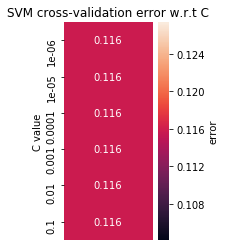

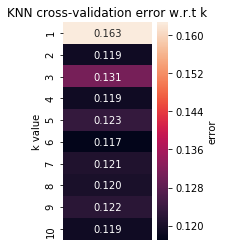

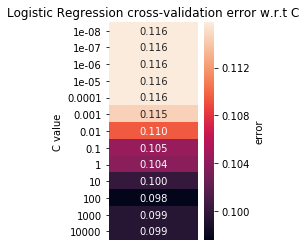

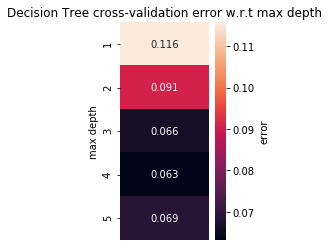

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 11.3min finished


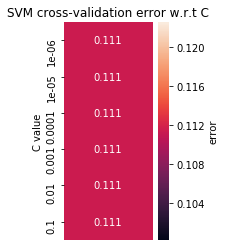

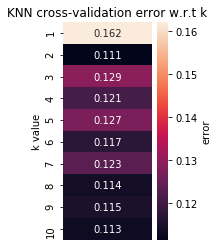

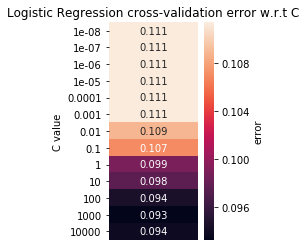

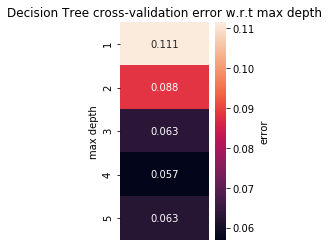

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  6.2min finished


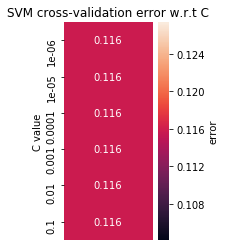

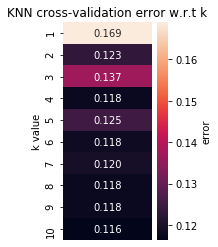

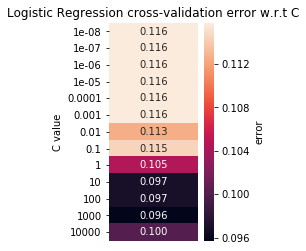

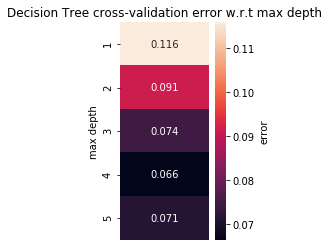

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  6.3min finished


20/80 train test split
avg SVM score: 0.8859168882632046 0.8856904463913226
avg KNN score: 0.8812763960581886 0.8959115561118064
avg logistic regression score: 0.9045831378069763 0.9069670421360033
avg decision tree score: 0.9323739506752177 0.9432624113475178
avg random forest score: 0.9480160592314512 0.9952023362536503


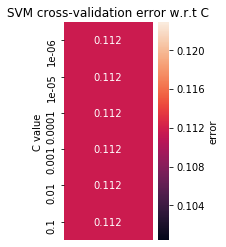

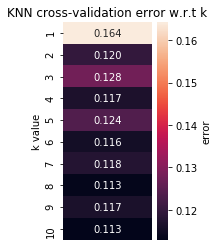

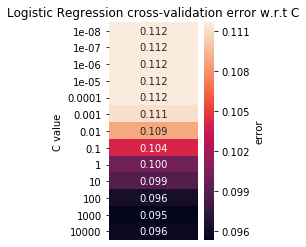

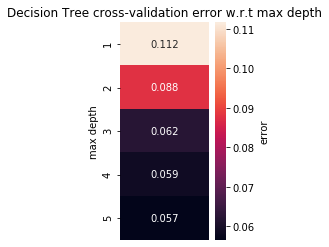

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 11.3min finished


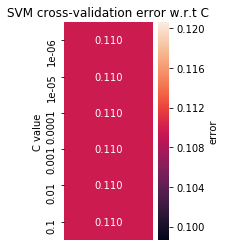

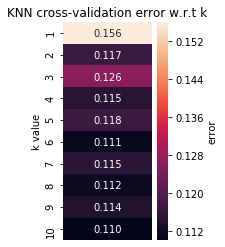

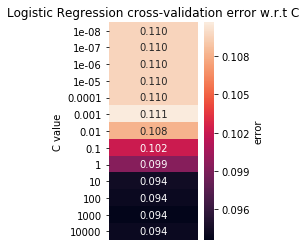

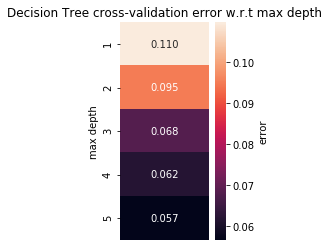

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 10.8min finished


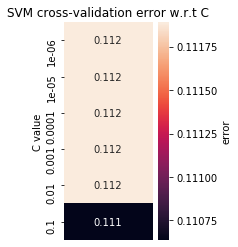

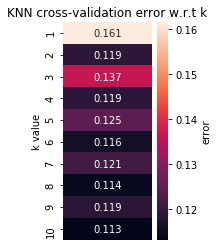

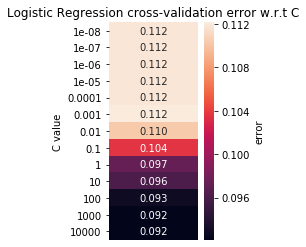

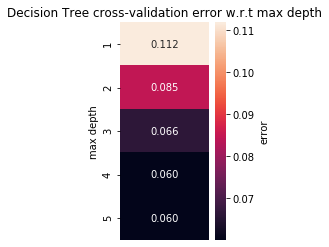

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 12.8min finished


50/50 train test split
avg SVM score: 0.8829662996329662 0.8889445139758031
avg KNN score: 0.8811311311311312 0.8931998331247392
avg logistic regression score: 0.9043209876543209 0.9074676679182311
avg decision tree score: 0.9420253586920252 0.9516896120150188
avg random forest score: 0.9502002002002001 0.9914893617021278


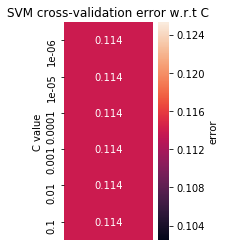

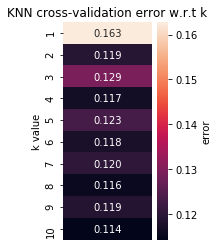

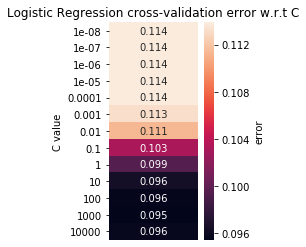

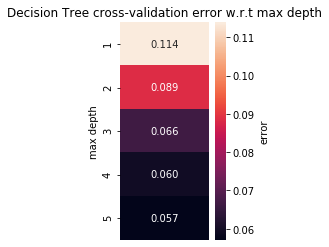

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 18.4min finished


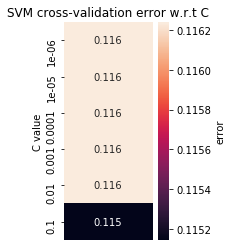

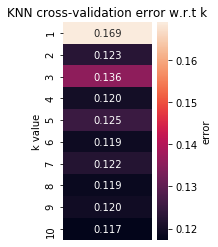

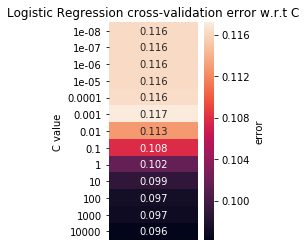

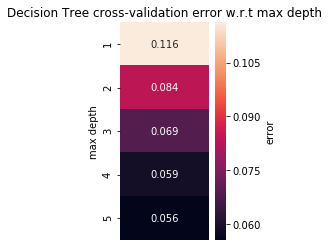

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 17.0min finished


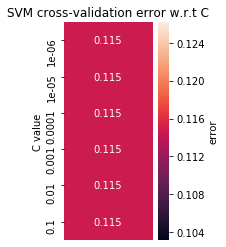

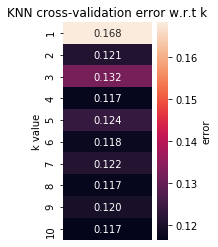

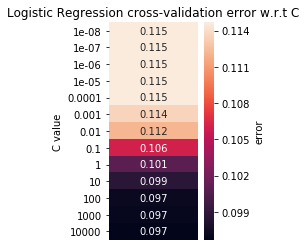

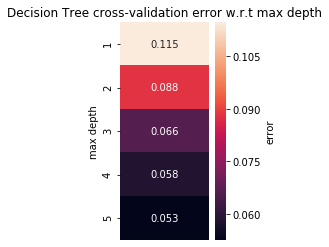

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 16.5min finished


80/20 train test split
avg SVM score: 0.8890973525119866 0.8850646641635378
avg KNN score: 0.8893058161350845 0.8909052982895286
avg logistic regression score: 0.9091098603293726 0.9053504380475594
avg decision tree score: 0.948509485094851 0.9505110554860243
avg random forest score: 0.9545549301646862 0.9958802670004173


In [5]:
#unabling all the warnings
import warnings
warnings.filterwarnings("ignore")
run(wi_data, wi_label)